In [1]:
import numpy as np
import pandas as pd
import h5py as h5
import os
from plotDrhoDt import modelColors,mnames
import matplotlib.pyplot as plt

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
obsFiles = {'site1': '46Density.tsv', 'site2': 'B26_2011.csv', 'site3': 'NEEM2007shallowcoreDensity.txt'}
rfolder = './CFMexperimentsInput2/'
models = ["HLdynamic","HLSigfus","Li2011","Helsen2008","Arthern2010S","Barnola1991","KuipersMunneke2015","Simonsen2013", "Crocus","Arthern2010T"]
sites = ['site'+str(x) for x in range(1,4)]

In [3]:
merge = {}
#merge1 = {}
def prepareObsAndModel():

    for s in sites:
        # observation profile
        obsFile = os.path.join('obsProfiles', obsFiles[s])
        obsProfile = pd.read_csv(obsFile)
        
        if s == 'site1': 
            obsTime = 2006.5
        elif s == 'site2':
            obsTime = 2011.5
        elif s=='site3':
             obsTime = 2007.5
        
    
        if len(obsProfile.columns)!=2:
            obsProfile = pd.read_csv(obsFile, delimiter='\t')
        #print(obsProfile.head())
        #modelProfile = {}
        merge[s] = pd.DataFrame()
        i = 1
        for m in models:
            
            rfile='CFM_'+s+'_results_'+m+'.hdf5'

            fn = os.path.join(rfolder,rfile)

            try:
                
                f = h5.File(fn,'r')
                
                # make sure the profile is coming from the right time
                time = list(f['depth'][:,0])
                #print(time)

                timeIndex = time.index(obsTime)
                modelDepth = f['depth'][timeIndex,1:]
                #print(modelDepth)
                modelDensity = f['density'][timeIndex,1:]    
                #print(modelDensity)
                modelProfile = pd.DataFrame()
                modelProfile['Depth [m]'] = modelDepth
                modelProfile[m+'Density [kg/m3]'] = modelDensity

                modelProfile = modelProfile[modelProfile['Depth [m]'] < max(obsProfile['Depth [m]']) ]
        
            except:
                continue
            
            if i==1:
                merge[s] = pd.merge(obsProfile, modelProfile, on='Depth [m]', how='outer')
                #merge[s] = merge1.copy()
            else:
                merge[s] = pd.merge(modelProfile, merge[s], on='Depth [m]', how='outer')
            
            i = i+1
            #print(merge)
        merge[s] = merge[s].sort_values(by='Depth [m]')
        merge[s] = merge[s].interpolate(pad=3) # fill missing values by linear interpolation
        #print(merge[s])
        merge[s] = merge[s][np.isfinite(merge[s]['Density [kg/m3]'])]
    return merge

In [4]:
def compute_error(trues, predicted):
    mae = round(np.mean(np.abs(predicted - trues)),3)
    rmse = round(np.sqrt(np.mean((predicted - trues)**2)),3)
    return mae, rmse

In [5]:
me= prepareObsAndModel()

In [6]:
def plot(dfDict):
    for s in sites:
        sProfileName = obsFiles[s].replace('.csv', '').replace('.txt','').replace('.tsv','')
        
        df = dfDict[s]
        
        obsDepth = df['Depth [m]']
        obsDensity = df['Density [kg/m3]']
        
        plt.figure()
        plt.gca().invert_yaxis()
        
        plt.step(obsDensity, obsDepth, label='Observation', c='black')

        for m in models:
            try: modelDensity = df[m+'Density [kg/m3]']
            except: continue

            plt.step(modelDensity,obsDepth, c=modelColors[m], label=mnames[m], linewidth=0.6)

        plt.legend(fontsize=8)
        plt.ylabel('Depth [m]')
        plt.xlabel('Density [kg/m3]')
        plt.title(sProfileName+'\n Depth Density Profile' )
        plt.show()
        
        if not os.path.exists(rfolder+'/plots'):
            os.makedirs(rfolder+'/plots')
        plt.savefig(rfolder+'/plots/ddp'+s+'.png', bbox_inches='tight')


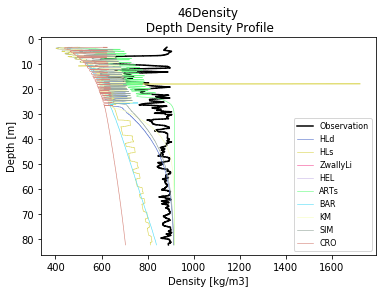

<Figure size 432x288 with 0 Axes>

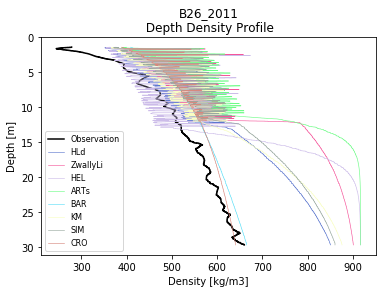

<Figure size 432x288 with 0 Axes>

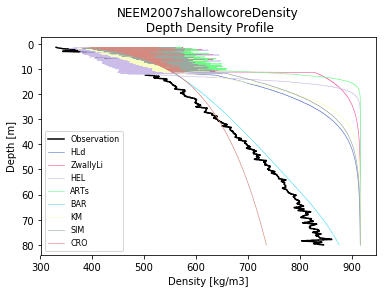

<Figure size 432x288 with 0 Axes>

In [7]:
plot(me)

In [8]:
def estimationError(deep=False):
    
    for s in sites:

        dfs = me[s]
        if not deep: dfs = dfs[dfs['Depth [m]'] <= 20]
        print(s)
        obsDensity = dfs['Density [kg/m3]']
        for m in models:
            try:
                modelDensity = dfs[m+'Density [kg/m3]']
                mae, rmse = compute_error(obsDensity, modelDensity)
                print(m, ' &', mae, ' &',rmse, '&')
            except: continue
        

In [9]:
# rmse for the first 20 m
estimationError()

site1
HLdynamic  & 189.175  & 225.451 &
HLSigfus  & 198.821  & 236.482 &
Li2011  & nan  & nan &
Helsen2008  & nan  & nan &
Arthern2010S  & 109.952  & 150.8 &
Barnola1991  & 199.978  & 229.527 &
KuipersMunneke2015  & 184.773  & 220.033 &
Simonsen2013  & 161.428  & 199.657 &
Crocus  & 204.848  & 236.7 &
site2
HLdynamic  & 67.224  & 85.079 &
Li2011  & 103.585  & 125.361 &
Helsen2008  & 68.759  & 96.797 &
Arthern2010S  & 158.196  & 171.0 &
Barnola1991  & 70.443  & 79.576 &
KuipersMunneke2015  & 79.633  & 94.637 &
Simonsen2013  & 100.511  & 110.235 &
Crocus  & 72.057  & 80.114 &
site3
HLdynamic  & 65.115  & 85.56 &
Li2011  & 107.731  & 136.281 &
Helsen2008  & 69.711  & 102.12 &
Arthern2010S  & 153.994  & 167.666 &
Barnola1991  & 63.853  & 68.366 &
KuipersMunneke2015  & 75.042  & 92.25 &
Simonsen2013  & 98.718  & 109.506 &
Crocus  & 65.89  & 71.098 &


In [10]:
# rmse for all
estimationError(True)

site1
HLdynamic  & 143.239  & 182.609 &
HLSigfus  & 173.322  & 200.154 &
Li2011  & nan  & nan &
Helsen2008  & nan  & nan &
Arthern2010S  & 77.838  & 113.128 &
Barnola1991  & 178.069  & 199.928 &
KuipersMunneke2015  & 140.152  & 178.125 &
Simonsen2013  & 122.692  & 160.69 &
Crocus  & 207.096  & 224.521 &
site2
HLdynamic  & 78.764  & 99.914 &
Li2011  & 118.889  & 144.776 &
Helsen2008  & 89.778  & 128.918 &
Arthern2010S  & 171.259  & 186.709 &
Barnola1991  & 66.088  & 76.161 &
KuipersMunneke2015  & 92.45  & 111.973 &
Simonsen2013  & 110.412  & 122.533 &
Crocus  & 66.331  & 76.41 &
site3
HLdynamic  & 103.817  & 125.016 &
Li2011  & 137.275  & 162.007 &
Helsen2008  & 116.44  & 149.088 &
Arthern2010S  & 165.618  & 180.583 &
Barnola1991  & 47.249  & 54.669 &
KuipersMunneke2015  & 113.606  & 134.209 &
Simonsen2013  & 125.17  & 138.199 &
Crocus  & 61.162  & 68.412 &
